# Deep Learning Model for Loan Default Prediction

This notebook implements and trains a deep learning classifier to predict loan default risk.
- Multi-layer perceptron architecture
- Training with early stopping
- Comprehensive evaluation metrics
- Model interpretation and analysis

In [2]:
# Import necessary libraries
import sys
import os
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from src.models.deep_learning_classifier import DeepLearningClassifier, LoanClassifierTrainer
from src.evaluation.metrics import ModelEvaluator
from src.evaluation.visualizations import ResultVisualizer
from src.utils.helpers import setup_logging, load_results, save_results
from config.config import MODEL_CONFIG

# Setup
setup_logging()
plt.style.use('seaborn-v0_8')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

2025-09-11 16:10:24,488 - src.utils.helpers - INFO - Logging setup complete. Level: INFO


## 1. Load Preprocessed Data

In [3]:
# Load preprocessed data
print("Loading preprocessed data...")
try:
    processed_data = load_results('preprocessed_data.pkl', '../data/processed/')
    
    X_train = processed_data['X_train']
    X_val = processed_data['X_val']
    X_test = processed_data['X_test']
    y_train = processed_data['y_train']
    y_val = processed_data['y_val']
    y_test = processed_data['y_test']
    feature_names = processed_data['feature_names']
    
    print(f"Data loaded successfully!")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Number of features: {len(feature_names)}")
    
except FileNotFoundError:
    print("Preprocessed data not found. Please run the preprocessing notebook first.")
    raise

Loading preprocessed data...
Data loaded successfully!
Training set: (53039, 35)
Validation set: (17680, 35)
Test set: (17680, 35)
Number of features: 35


Class distribution analysis:
Training set - Class 0: 42172 (79.5%)
Training set - Class 1: 10867 (20.5%)
Default rate in training: 20.5%


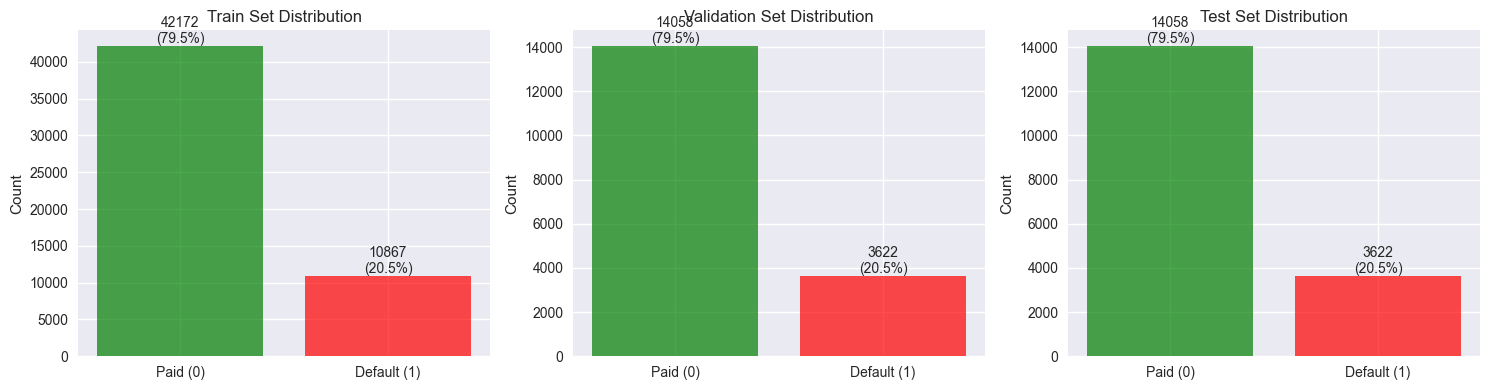

In [4]:
# Analyze class distribution
print("Class distribution analysis:")
print(f"Training set - Class 0: {np.sum(y_train == 0)} ({np.mean(y_train == 0)*100:.1f}%)")
print(f"Training set - Class 1: {np.sum(y_train == 1)} ({np.mean(y_train == 1)*100:.1f}%)")
print(f"Default rate in training: {np.mean(y_train)*100:.1f}%")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
datasets = [('Train', y_train), ('Validation', y_val), ('Test', y_test)]

for i, (name, y) in enumerate(datasets):
    unique, counts = np.unique(y, return_counts=True)
    axes[i].bar(['Paid (0)', 'Default (1)'], counts, color=['green', 'red'], alpha=0.7)
    axes[i].set_title(f'{name} Set Distribution')
    axes[i].set_ylabel('Count')
    
    # Add percentage labels
    total = len(y)
    for j, count in enumerate(counts):
        axes[i].text(j, count, f'{count}\n({count/total*100:.1f}%)', 
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 2. Model Architecture Design

In [5]:
# Define model parameters
input_dim = X_train.shape[1]
hidden_layers = MODEL_CONFIG.dl_hidden_layers
dropout_rate = MODEL_CONFIG.dl_dropout_rate

print("Model Configuration:")
print(f"Input dimension: {input_dim}")
print(f"Hidden layers: {hidden_layers}")
print(f"Dropout rate: {dropout_rate}")
print(f"Learning rate: {MODEL_CONFIG.dl_learning_rate}")
print(f"Batch size: {MODEL_CONFIG.dl_batch_size}")
print(f"Max epochs: {MODEL_CONFIG.dl_epochs}")
print(f"Early stopping patience: {MODEL_CONFIG.dl_early_stopping_patience}")

# Create model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

model = DeepLearningClassifier(
    input_dim=input_dim,
    hidden_layers=hidden_layers,
    dropout_rate=dropout_rate
)

print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model Configuration:
Input dimension: 35
Hidden layers: [256, 128, 64, 32]
Dropout rate: 0.3
Learning rate: 0.001
Batch size: 256
Max epochs: 100
Early stopping patience: 10

Using device: cpu

Model architecture:
DeepLearningClassifier(
  (network): Sequential(
    (0): Linear(in_features=35, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(32, eps=1e-05, mo

## 3. Model Training

In [6]:
# Initialize trainer
trainer = LoanClassifierTrainer(model, device=device)

print("Starting model training...")
print(f"Training on {len(X_train)} samples")
print(f"Validating on {len(X_val)} samples")

# Train the model
training_history = trainer.train(X_train, y_train, X_val, y_val)

print("\nTraining completed!")
print(f"Best validation AUC: {training_history['best_val_auc']:.4f}")
print(f"Training stopped after {len(training_history['train_losses'])} epochs")

Starting model training...
Training on 53039 samples
Validating on 17680 samples


2025-09-11 16:10:53,591 - src.models.deep_learning_classifier - INFO - Epoch 0: Train Loss: 0.6070, Val Loss: 0.4987, Val AUC: 0.7255
2025-09-11 16:11:14,562 - src.models.deep_learning_classifier - INFO - Epoch 10: Train Loss: 0.4467, Val Loss: 0.4475, Val AUC: 0.7367
2025-09-11 16:11:32,705 - src.models.deep_learning_classifier - INFO - Epoch 20: Train Loss: 0.4401, Val Loss: 0.4482, Val AUC: 0.7354
2025-09-11 16:11:41,160 - src.models.deep_learning_classifier - INFO - Early stopping at epoch 24



Training completed!
Best validation AUC: 0.7375
Training stopped after 25 epochs


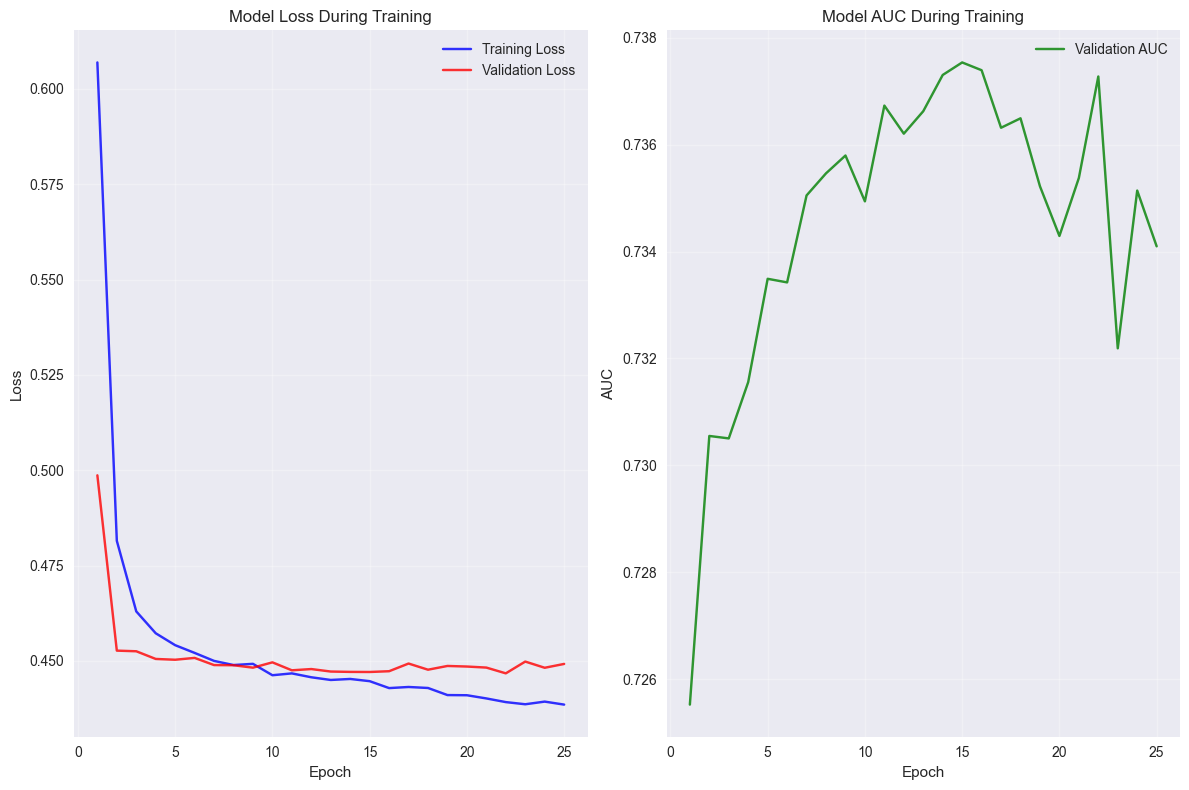

Training Statistics:
Final training loss: 0.4385
Final validation loss: 0.4492
Final validation AUC: 0.7341
Best validation AUC: 0.7375


In [7]:
# Visualize training history
visualizer = ResultVisualizer()
fig = visualizer.plot_training_history(training_history, 
                                      save_path='../results/figures/dl_training_history.png')
plt.show()

# Print training statistics
print("Training Statistics:")
print(f"Final training loss: {training_history['train_losses'][-1]:.4f}")
print(f"Final validation loss: {training_history['val_losses'][-1]:.4f}")
print(f"Final validation AUC: {training_history['val_aucs'][-1]:.4f}")
print(f"Best validation AUC: {training_history['best_val_auc']:.4f}")

## 4. Model Evaluation

In [8]:
# Evaluate on test set
print("Evaluating model on test set...")
test_results = trainer.evaluate(X_test, y_test)

print("\nTest Set Results:")
print(f"AUC: {test_results['auc']:.4f}")
print(f"F1 Score: {test_results['f1']:.4f}")
print("\nClassification Report:")
print(test_results['classification_report'])

Evaluating model on test set...


2025-09-11 16:13:59,480 - src.models.deep_learning_classifier - INFO - Test AUC: 0.7415, Test F1: 0.1743



Test Set Results:
AUC: 0.7415
F1 Score: 0.1743

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     14058
           1       0.56      0.10      0.17      3622

    accuracy                           0.80     17680
   macro avg       0.68      0.54      0.53     17680
weighted avg       0.76      0.80      0.74     17680



In [9]:
# Detailed evaluation using ModelEvaluator
evaluator = ModelEvaluator()
detailed_results = evaluator.evaluate_classifier(
    y_test, test_results['probabilities'], test_results['predictions'], 
    model_name="Deep Learning Classifier"
)

print("\nDetailed Evaluation Metrics:")
print(f"AUC: {detailed_results['auc']:.4f}")
print(f"F1 Score: {detailed_results['f1_score']:.4f}")
print(f"Precision: {detailed_results['precision']:.4f}")
print(f"Recall: {detailed_results['recall']:.4f}")
print(f"Specificity: {detailed_results['specificity']:.4f}")
print(f"NPV: {detailed_results['npv']:.4f}")

2025-09-11 16:14:03,018 - src.evaluation.metrics - INFO - Deep Learning Classifier - AUC: 0.7415, F1: 0.1743, Precision: 0.5582, Recall: 0.1033



Detailed Evaluation Metrics:
AUC: 0.7415
F1 Score: 0.1743
Precision: 0.5582
Recall: 0.1033
Specificity: 0.9789
NPV: 0.8091


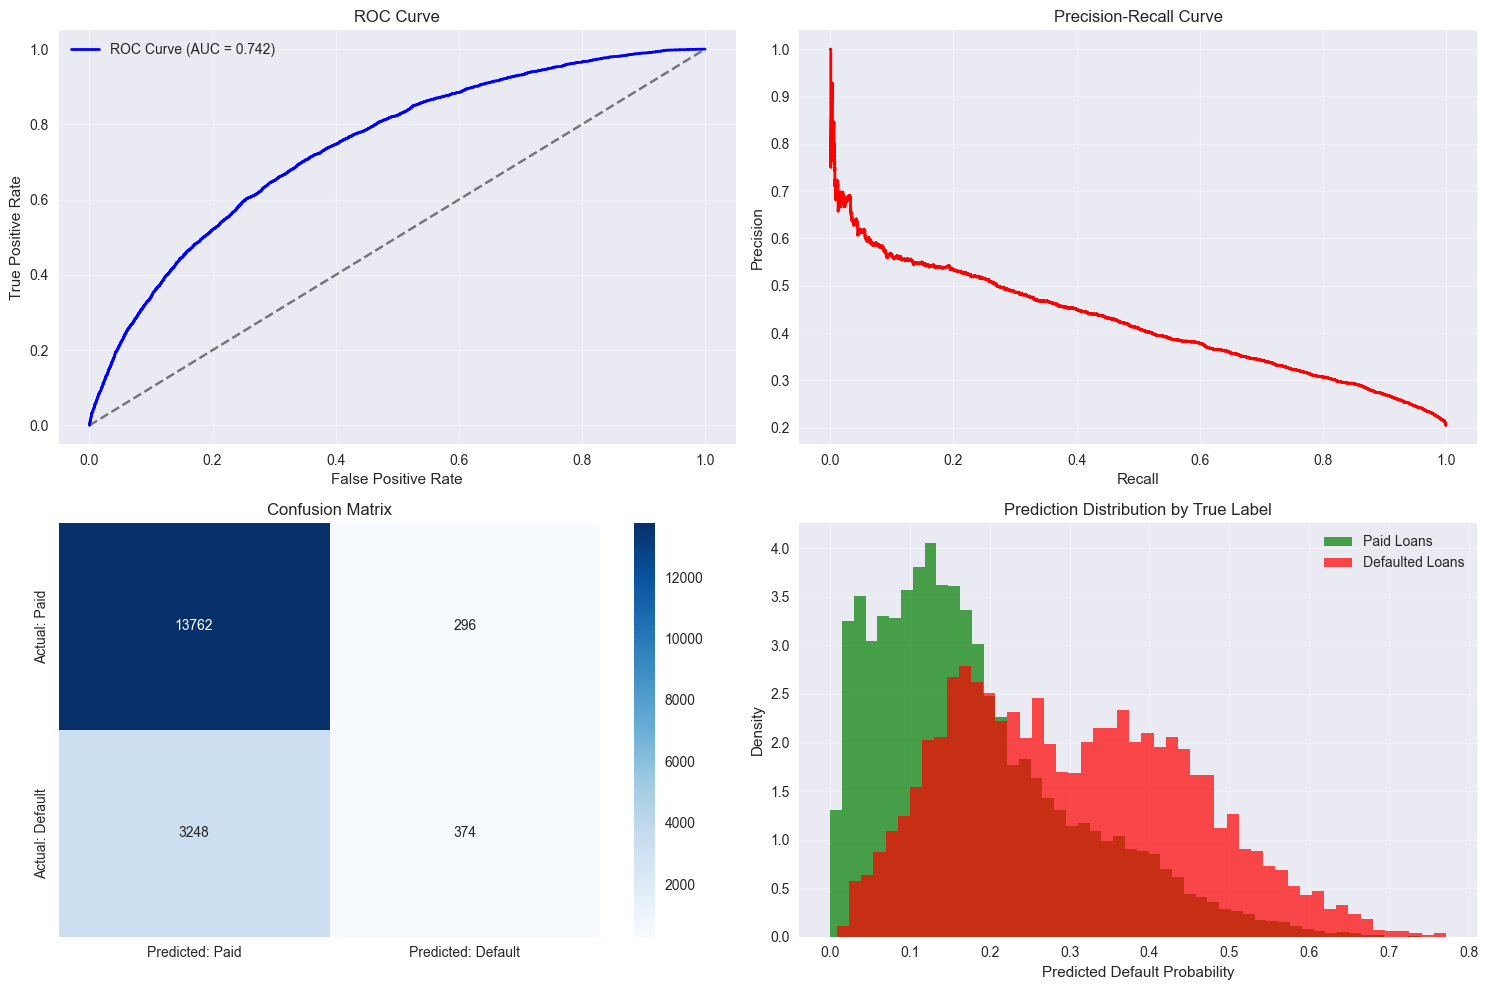

In [10]:
# Visualize evaluation results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ROC Curve
roc_data = detailed_results['roc_curve']
axes[0, 0].plot(roc_data['fpr'], roc_data['tpr'], 'b-', linewidth=2, 
               label=f'ROC Curve (AUC = {detailed_results["auc"]:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall Curve
pr_data = detailed_results['pr_curve']
axes[0, 1].plot(pr_data['recall'], pr_data['precision'], 'r-', linewidth=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix
cm = detailed_results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
           xticklabels=['Predicted: Paid', 'Predicted: Default'],
           yticklabels=['Actual: Paid', 'Actual: Default'])
axes[1, 0].set_title('Confusion Matrix')

# Prediction distribution
axes[1, 1].hist(test_results['probabilities'][y_test==0], bins=50, alpha=0.7, 
               label='Paid Loans', color='green', density=True)
axes[1, 1].hist(test_results['probabilities'][y_test==1], bins=50, alpha=0.7, 
               label='Defaulted Loans', color='red', density=True)
axes[1, 1].set_xlabel('Predicted Default Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Prediction Distribution by True Label')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/dl_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Threshold Analysis

In [11]:
# Perform threshold analysis
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_df = evaluator.threshold_analysis(y_test, test_results['probabilities'], thresholds)

print("Threshold Analysis Results:")
print(threshold_df.round(3))

# Find optimal threshold based on F1 score
optimal_idx = threshold_df['f1_score'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'f1_score']

print(f"\nOptimal threshold (F1): {optimal_threshold:.2f} (F1 = {optimal_f1:.3f})")

Threshold Analysis Results:
    threshold    auc  f1_score  precision  recall  approval_rate
0        0.10  0.742     0.401      0.256   0.931          0.254
1        0.15  0.742     0.437      0.296   0.831          0.425
2        0.20  0.742     0.460      0.342   0.702          0.579
3        0.25  0.742     0.463      0.381   0.591          0.683
4        0.30  0.742     0.448      0.415   0.487          0.760
5        0.35  0.742     0.417      0.452   0.387          0.825
6        0.40  0.742     0.359      0.497   0.281          0.884
7        0.45  0.742     0.270      0.538   0.180          0.931
8        0.50  0.742     0.174      0.558   0.103          0.962
9        0.55  0.742     0.104      0.602   0.057          0.981
10       0.60  0.742     0.057      0.686   0.030          0.991
11       0.65  0.742     0.020      0.712   0.010          0.997
12       0.70  0.742     0.006      0.909   0.003          0.999
13       0.75  0.742     0.001      1.000   0.001          1.0

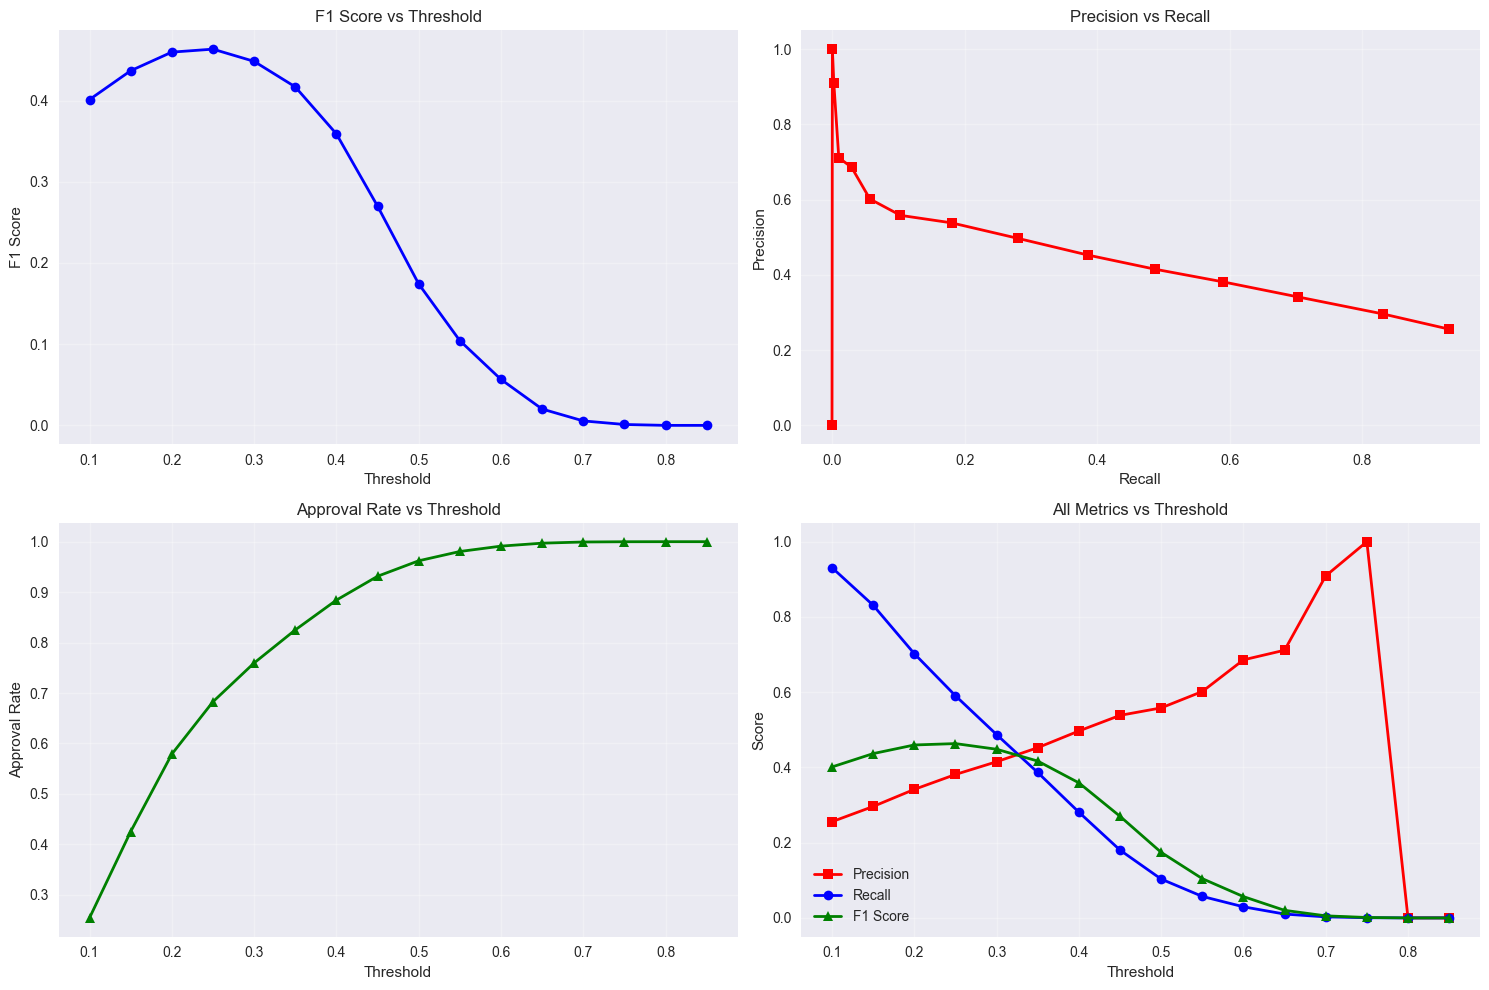

In [12]:
# Visualize threshold analysis
fig = visualizer.plot_threshold_analysis(threshold_df, 
                                        save_path='../results/figures/dl_threshold_analysis.png')
plt.show()

## 6. Feature Importance Analysis

In [13]:
# Calculate feature importance using gradients
def calculate_feature_importance(model, X, y, feature_names):
    """Calculate feature importance using gradient-based method."""
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y).to(device)
    
    X_tensor.requires_grad_()
    
    # Forward pass
    outputs = model(X_tensor).squeeze()
    loss = nn.BCELoss()(outputs, y_tensor)
    
    # Backward pass
    loss.backward()
    
    # Get gradients
    gradients = X_tensor.grad.abs().mean(dim=0).cpu().numpy()
    
    return gradients

# Calculate feature importance
print("Calculating feature importance...")
feature_importance = calculate_feature_importance(model, X_test, y_test, feature_names)

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(importance_df.head(15))

Calculating feature importance...

Top 15 Most Important Features:
                         feature  importance
0                      loan_amnt    0.000014
2                    installment    0.000010
1                       int_rate    0.000008
30                purpose_moving    0.000004
32      purpose_renewable_energy    0.000004
3                     annual_inc    0.000004
33        purpose_small_business    0.000004
4                            dti    0.000003
21           home_ownership_RENT    0.000003
34              purpose_vacation    0.000003
8                       open_acc    0.000003
10                     revol_bal    0.000003
19       home_ownership_MORTGAGE    0.000002
26      purpose_home_improvement    0.000002
23  verification_status_Verified    0.000002


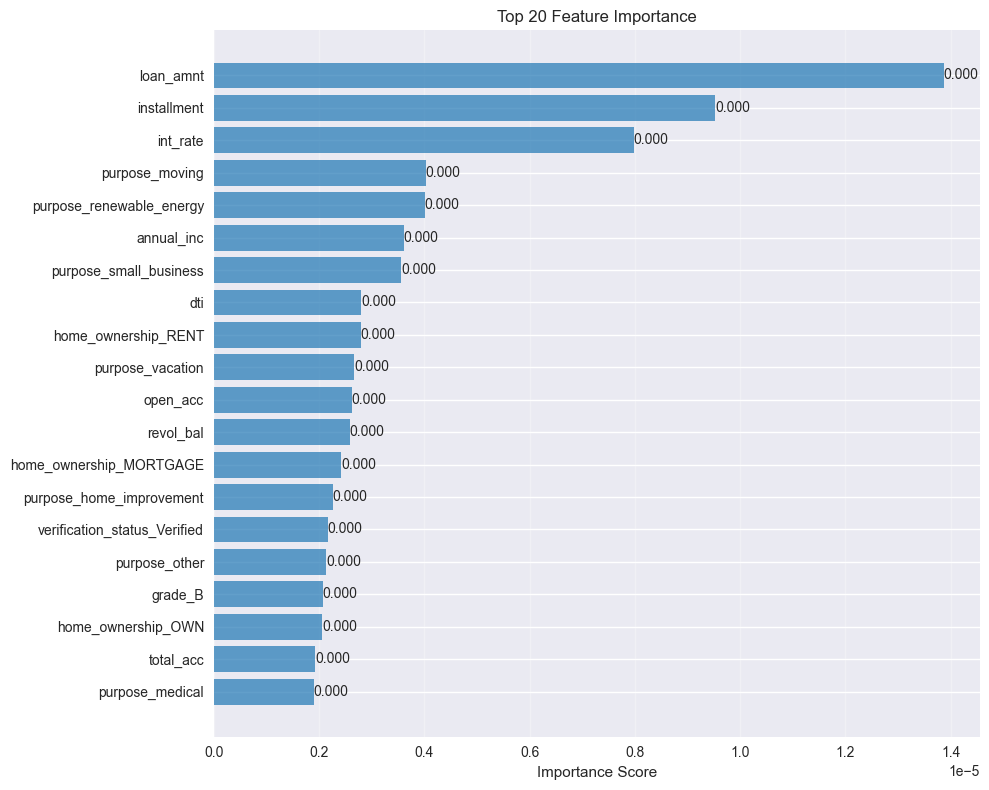

Feature importance saved to '../results/dl_feature_importance.csv'


In [14]:
# Visualize feature importance
fig = visualizer.plot_feature_importance(feature_names, feature_importance, top_n=20,
                                        save_path='../results/figures/dl_feature_importance.png')
plt.show()

# Save feature importance
importance_df.to_csv('../results/dl_feature_importance.csv', index=False)
print("Feature importance saved to '../results/dl_feature_importance.csv'")

## 7. Model Interpretability

Risk Bucket Analysis:
  Risk_Bucket  Count  Actual_Default_Rate  Avg_Predicted_Prob
0    Very Low  10233                0.105               0.107
1         Low   5398                0.283               0.287
2      Medium   1893                0.481               0.469
3        High    156                0.686               0.642
4   Very High      0                  NaN                 NaN


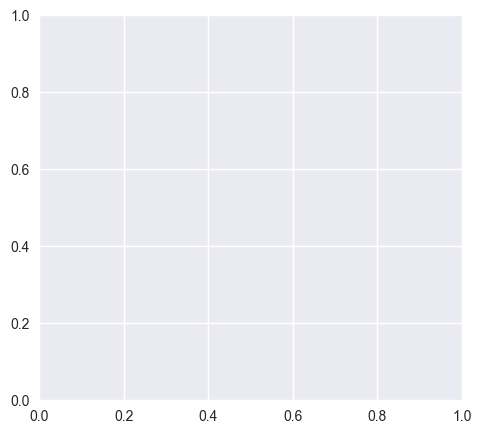

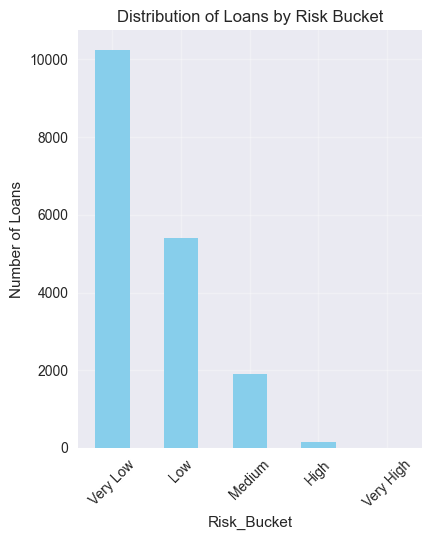

In [15]:
# Analyze model predictions by risk buckets
test_probabilities = test_results['probabilities']

# Create risk buckets
risk_buckets = pd.cut(test_probabilities, bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                     labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Analyze each bucket
bucket_analysis = pd.DataFrame({
    'Risk_Bucket': risk_buckets.categories,
    'Count': risk_buckets.value_counts().sort_index().values,
    'Actual_Default_Rate': [y_test[risk_buckets == bucket].mean() 
                           for bucket in risk_buckets.categories],
    'Avg_Predicted_Prob': [test_probabilities[risk_buckets == bucket].mean() 
                          for bucket in risk_buckets.categories]
})

print("Risk Bucket Analysis:")
print(bucket_analysis.round(3))

# Visualize calibration
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bucket_analysis.set_index('Risk_Bucket')[['Actual_Default_Rate', 'Avg_Predicted_Prob']].plot(kind='bar')
plt.title('Model Calibration by Risk Bucket')
plt.ylabel('Default Rate / Predicted Probability')
plt.xticks(rotation=45)
plt.legend(['Actual Default Rate', 'Predicted Probability'])
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
bucket_analysis.set_index('Risk_Bucket')['Count'].plot(kind='bar', color='skyblue')
plt.title('Distribution of Loans by Risk Bucket')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/dl_model_calibration.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Save Model and Results

In [16]:
# Save model results
dl_results = {
    'model_name': 'Deep Learning Classifier',
    'test_metrics': {
        'auc': float(detailed_results['auc']),
        'f1_score': float(detailed_results['f1_score']),
        'precision': float(detailed_results['precision']),
        'recall': float(detailed_results['recall']),
        'specificity': float(detailed_results['specificity'])
    },
    'training_history': {
        'best_val_auc': float(training_history['best_val_auc']),
        'final_train_loss': float(training_history['train_losses'][-1]),
        'final_val_loss': float(training_history['val_losses'][-1]),
        'epochs_trained': len(training_history['train_losses'])
    },
    'model_config': {
        'input_dim': int(input_dim),
        'hidden_layers': hidden_layers,
        'dropout_rate': float(dropout_rate),
        'total_parameters': int(total_params),
        'learning_rate': float(MODEL_CONFIG.dl_learning_rate),
        'batch_size': int(MODEL_CONFIG.dl_batch_size)
    },
    'predictions': {
        'test_probabilities': test_probabilities.tolist(),
        'test_predictions': test_results['predictions'].tolist(),
        'optimal_threshold': float(optimal_threshold)
    },
    'feature_importance': importance_df.to_dict('records'),
    'risk_bucket_analysis': bucket_analysis.to_dict('records')
}

# Save results
save_results(dl_results, 'deep_learning_results.json', '../results/')
print("Deep learning results saved to '../results/deep_learning_results.json'")

# Save model state
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'hidden_layers': hidden_layers,
        'dropout_rate': dropout_rate
    },
    'feature_names': feature_names
}, '../results/models/deep_learning_classifier.pth')
print("Model saved to '../results/models/deep_learning_classifier.pth'")

print("\n" + "="*50)
print("DEEP LEARNING MODEL SUMMARY")
print("="*50)
print(f"Model: Multi-Layer Perceptron")
print(f"Architecture: {input_dim} -> {' -> '.join(map(str, hidden_layers))} -> 1")
print(f"Total Parameters: {total_params:,}")
print(f"Training Epochs: {len(training_history['train_losses'])}")
print(f"\nTest Performance:")
print(f"AUC: {detailed_results['auc']:.4f}")
print(f"F1 Score: {detailed_results['f1_score']:.4f}")
print(f"Precision: {detailed_results['precision']:.4f}")
print(f"Recall: {detailed_results['recall']:.4f}")
print(f"\nOptimal Decision Threshold: {optimal_threshold:.2f}")
print(f"\nTop 3 Important Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
print("\nDeep Learning model training completed successfully!")

Results saved to: ../results/deep_learning_results.json
Deep learning results saved to '../results/deep_learning_results.json'
Model saved to '../results/models/deep_learning_classifier.pth'

DEEP LEARNING MODEL SUMMARY
Model: Multi-Layer Perceptron
Architecture: 35 -> 256 -> 128 -> 64 -> 32 -> 1
Total Parameters: 53,441
Training Epochs: 25

Test Performance:
AUC: 0.7415
F1 Score: 0.1743
Precision: 0.5582
Recall: 0.1033

Optimal Decision Threshold: 0.25

Top 3 Important Features:
  1. loan_amnt: 0.0000
  3. installment: 0.0000
  2. int_rate: 0.0000

Deep Learning model training completed successfully!
